In [19]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import rcParams 
rcParams['figure.figsize'] = 12, 12

import seaborn as sns
sns.set(style = 'darkgrid')

In [2]:
df = pd.read_csv('temps.csv')

In [3]:
df.head()

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
0,2016,1,1,Fri,45,45,45.6,45,43,50,44,29
1,2016,1,2,Sat,44,45,45.7,44,41,50,44,61
2,2016,1,3,Sun,45,44,45.8,41,43,46,47,56
3,2016,1,4,Mon,44,41,45.9,40,44,48,46,53
4,2016,1,5,Tues,41,40,46.0,44,46,46,46,41


In [4]:
df.shape

(348, 12)

In [5]:
df.describe()

,year,month,day,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend
count,348.0,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000,348.000000
mean,2016.0,6.477011,15.514368,62.652299,62.701149,59.760632,62.543103,57.238506,62.373563,59.772989,60.034483
std,0.0,3.498380,8.772982,12.165398,12.120542,10.527306,11.794146,10.605746,10.549381,10.705256,15.626179
min,2016.0,1.000000,1.000000,35.000000,35.000000,45.100000,35.000000,41.000000,46.000000,44.000000,28.000000
25%,2016.0,3.000000,8.000000,54.000000,54.000000,49.975000,54.000000,48.000000,53.000000,50.000000,47.750000
50%,2016.0,6.000000,15.000000,62.500000,62.500000,58.200000,62.500000,56.000000,61.000000,58.000000,60.000000
75%,2016.0,10.000000,23.000000,71.000000,71.000000,69.025000,71.000000,66.000000,72.000000,69.000000,71.000000
max,2016.0,12.000000,31.000000,117.000000,117.000000,77.400000,92.000000,77.000000,82.000000,79.000000,95.000000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 348 entries, 0 to 347
Data columns (total 12 columns):
year              348 non-null int64
month             348 non-null int64
day               348 non-null int64
week              348 non-null object
temp_2            348 non-null int64
temp_1            348 non-null int64
average           348 non-null float64
actual            348 non-null int64
forecast_noaa     348 non-null int64
forecast_acc      348 non-null int64
forecast_under    348 non-null int64
friend            348 non-null int64
dtypes: float64(1), int64(10), object(1)
memory usage: 32.7+ KB


In [7]:
#Creating the actual date by combining year, month and day
df['date'] = df['year'].astype('str') + "-" + df['month'].astype('str') + "-" + df['day'].astype('str')
df["date"] = pd.to_datetime(df["date"])

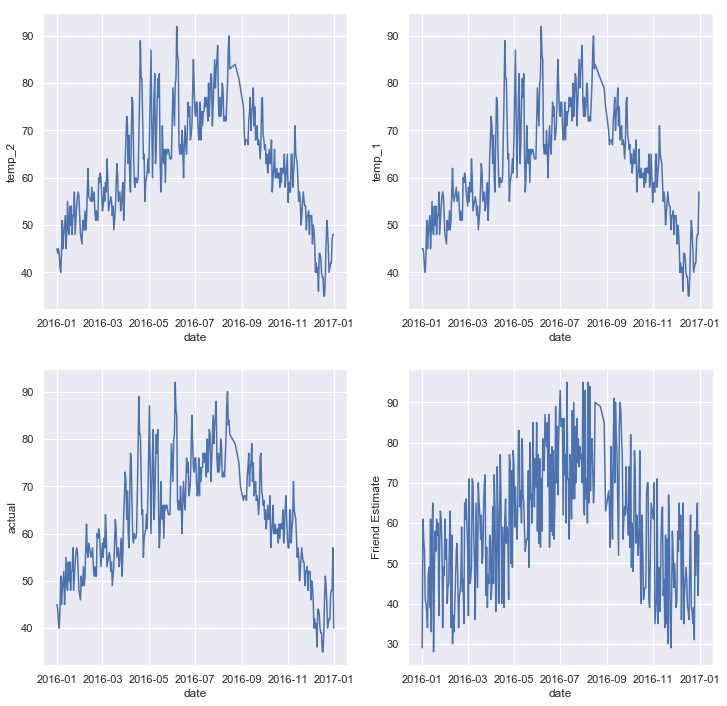

In [20]:
#plotting the 4 different metrics we have for the temperatures
plt.subplot(2,2,1)
sns.lineplot(df.date, df.temp_2)

plt.subplot(2,2,2)
sns.lineplot(df.date, df.temp_1)

plt.subplot(2,2,3)
sns.lineplot(df.date, df.actual)

plt.subplot(2,2,4)
sns.lineplot(df.date, df.friend)
plt.ylabel("Friend Estimate")

plt.show()

One data point near november seems to be way off for temp_2 and temp_1 (two days prior maximum and yesterday maximum respectively). Let us take a closer look at that row and clean it up.  

In [9]:
df[df.temp_1 > 100]

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,date
286,2016,10,31,Mon,65,117,54.8,59,51,59,56,62,2016-10-31


In [10]:
df[df.date=='2016-10-30']

,year,month,day,week,temp_2,temp_1,average,actual,forecast_noaa,forecast_acc,forecast_under,friend,date


There seems to be no data for the 30th of October, probably the reason as to why the previous day max shows a wierd number for 10/31. We can either impute that number with the average or eliminate the row completely. Because we only have 348 data points, imputation would be more ideal to retain as much data as possible. 

In [11]:
#setting the anomalies as equal to the average temperatures
temp = df.iloc[286,]['average']
df['temp_1'] = np.where(df.temp_1 > 100, temp, df.temp_1)
df['temp_2'] = np.where(df.temp_2 > 100, temp, df.temp_2)

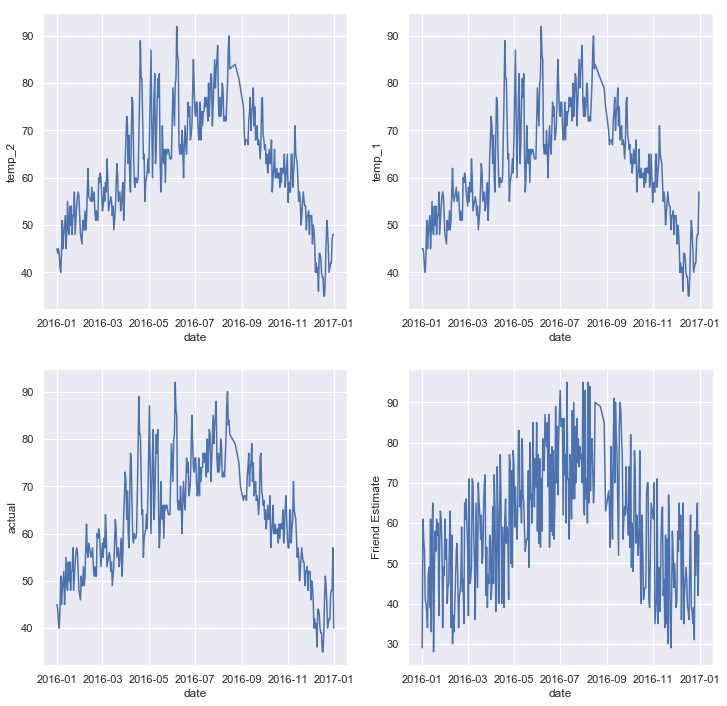

In [21]:
#plotting to ensure that our imputation worked. 
plt.subplot(2,2,1)
sns.lineplot(df.date, df.temp_2)

plt.subplot(2,2,2)
sns.lineplot(df.date, df.temp_1)

plt.subplot(2,2,3)
sns.lineplot(df.date, df.actual)

plt.subplot(2,2,4)
sns.lineplot(df.date, df.friend)
plt.ylabel("Friend Estimate")

plt.show()

### Model building 

First, we'll attempt to build a RF model which uses the month, average, temp_1, and temp_2 fields to predict the actual max for current day.

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [14]:
#sunsetting the data frame and seperating the target into a seperate variable
fields = ['month', 'average', 'temp_1', 'temp_2']
data = df[fields]
y = df.actual

In [15]:
#splitting the data
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.2, random_state = 123)

#fitting the model and making predictions
rf = RandomForestRegressor(n_estimators = 100, random_state = 123)
rf_model = rf.fit(X_train, y_train)
predictions = rf_model.predict(X_test)

In [16]:
#baseline accuracy vs model accuracy
baseline = X_test['average']
baseline_errors = abs(baseline - y_test)
print('Average baseline error:', np.round(np.mean(baseline_errors), 2), 'degrees')

model_errors = abs(predictions - y_test)
print('Average model error:', np.round(np.mean(model_errors), 2), 'degrees')

#MAPE 
mape = 100*np.mean(model_errors/y_test)
print("\nMAPE is", round(mape,3),"%")

Average baseline error: 5.3 degrees
Average model error: 3.39 degrees

MAPE is 5.404 %


In [17]:
# Pull out one tree from the forest
tree = rf.estimators_[5]
print('The depth of this tree is:', tree.tree_.max_depth)

The depth of this tree is: 14


In [18]:
#Important features
importances = list(rf_model.feature_importances_)

#List of tuples with features and their importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(data.columns, importances)]

#sorting them in descending order
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: average              Importance: 0.52
Variable: temp_1               Importance: 0.42
Variable: temp_2               Importance: 0.04
Variable: month                Importance: 0.02
